# Iterativne metode

## Minimalne ploskve s konjugiranimi gradienti
Vrnimo se k enačbam za minimalno ploskev na kvadratni mreži. Enačbe za vrednosti $U_{ij} = u(x_j,y_i)$ se glasijo

$$ U_{ij+1}+U_{i+1j}-4U_{ij}+U_{ij-1}+U_{i-1j} = 0$$

S preprosto ureditvijo dobimo enostavno iteracijsko formulo (Jacobijeva iteracija)

$$ U_{ij} = \frac{1}{4}\left(U_{ij+1}+U_{i+1j}+U_{ij-1}+U_{i-1j}\right), $$

ki jo lahko zelo preprosto implementiramo.


In [1]:
%load  jacobi.m

In [ ]:
function [U,i] = jacobi(U0,maxit,tol)
% funkcija U = jacobi(U0,maxit,tol) izračuna rešitev diskretizirane Laplaceove
% enačbe z Jacobijevo iteracijo z danim začetnim približkom U0
% vrednosti na robu U0 ustrezajo robnim pogojem
[m,n] = size(U0);

U = U0;

for i=1:maxit
    U(2:m-1,2:n-1) = (U(3:m,2:n-1) + U(1:m-2,2:n-1) + U(2:m-1,3:n) + U(2:m-1,1:n-2))/4;
    if max(max(abs(U-U0))) < tol
       break
    end
    U0 = U;
end


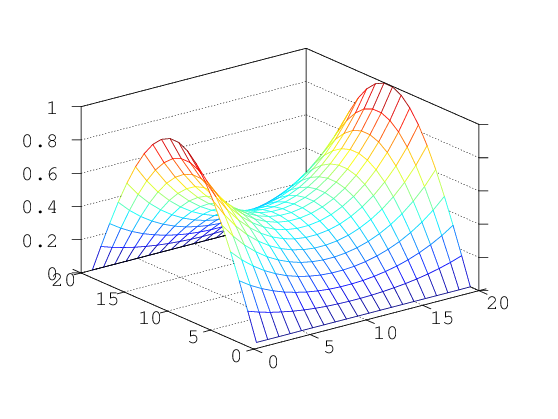

In [25]:
U0 = zeros(20);
U0(:,1) = sin(linspace(0,pi,20));
U0(:,20) = U0(:,1);
[U,i] = jacobi(U0,2000,1e-5);
mesh(U)

In [10]:
i

i =  494


In [11]:
[U,i] = gs(U0,2000,1e-5); i

i =  274


In [16]:
[U,it] = sor(U0,1.7,2000,1e-5); it

it =  50


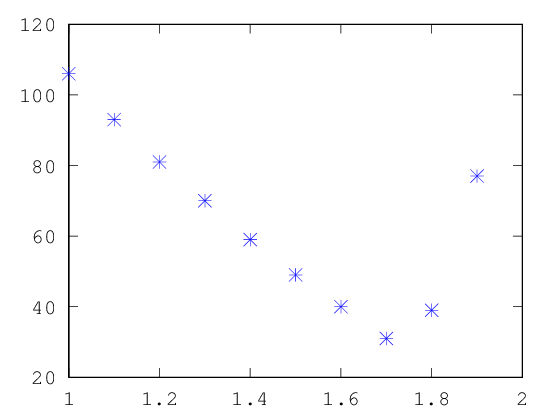

In [17]:
omega = linspace(1,1.9,10);
iter = zeros(size(omega));
for i = 1:10
  [U,it] = sor(U0,omega(i),2000,1e-3);
  iter(i) = it;
end
plot(omega,iter,'*')

# Metoda konjugiranih gradientov
Malce bolj komplicirana je metoda konjugiranih gradientov. Zato je ne bomo implementirali, ampak si bomo pogledali, kako jo lahko uporabimo, ne da bi nam bilo treba napisati matriko sistema.


In [16]:
%help pcg

In [18]:
%load cg.m

In [ ]:
function [U,it] = cg(U0,maxit,tol)
% funkcija U = cg(U0,omega,maxit,tol) izračuna rešitev diskretizirane Laplaceove
% enačbe z CG iteracijo z danim začetnim približkom U0
% vrednosti na robu U0 ustrezajo robnim pogojem

[m,n] = size(U0);
idx0 = find(U0); %indeksi fiksnih spremenljivk
idx = setdiff(1:n*m,idx0); % komplement idx0
b = -leva_stran(U0,idx);

[x, flag, relres,it]  = pcg(@(x) Akratx(x,m,n,idx), b);

U = U0;
U(idx) = x;
endfunction

function x = leva_stran(U,idx)
% funkcija izračuna desno stran Laplaceove enačbe, pri čemer
% upošteva le elemnte, ki so v idx
[m,n] = size(U);
x = U;
x(2:m-1,2:n-1) = 4*U(2:m-1,2:n-1)-(U(3:m,2:n-1) + U(1:m-2,2:n-1) + U(2:m-1,3:n) + U(2:m-1,1:n-2));
x = x(idx)'; % vrnemo le elemnte, ki so v idx
endfunction

function b = Akratx(x,m,n,idx)
U = zeros(m,n);
U(idx)=x;
b = leva_stran(U,idx);
endfunction


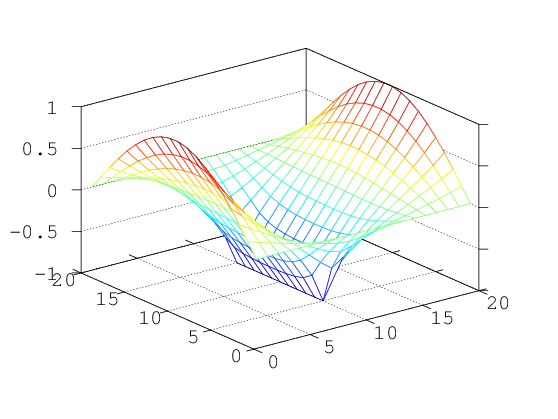

In [26]:
% U0(:,10) = -sin(linspace(0,pi,20));
U0(5:15,10) = -1;
[U,i] = cg(U0,10,1e-5);
mesh(U)

In [19]:
i

i =  10


# Fizikalna metoda za risanje grafov
Ogledali si bomo metodo za risanje grafov, ki temelji na fizikalnem modelu. Zamislimo si, da je vsaka povezava v grafu  idealna vzmet z elastično energijo

$$\frac{1}{2}k_{ij}\|\mathbf{x_i}-\mathbf{x_j}\|^2,$$

kjer so $\mathbf{x_i}$ in $\mathbf{x_j}$ koordinate vozlišč $i$ in $j$. Nekatere točke fiksiramo, za ostale pa bi radi poiskali položaj, pri katerih bodo vzmeti v ravnovesju. Ravnovesna lega je lega, pri kateri je energija vseh vzmeti minimalna

$$E = \frac{1}{2}\sum_{i,j}k_{ij}\|\mathbf{x_i}-\mathbf{x_j}\|^2.$$

Enačbe dobimo tako, da gradient energije izenačimo z 0.

$$\frac{\partial E}{\partial x_i}= \sum_j k_{ij}(x_i - x_j) = \left(\sum_j k_{ij}\right)x_i +\sum_j k_{ij} x_j=0.$$

Podobno dobimo za $y_i$. 

$$\frac{\partial E}{\partial y_i}=\left(\sum_j k_{ij}\right)y_i +\sum_j k_{ij} y_j=0$$

Očitno so enačbe za $x$ in $y$ nepovezane in jih lahko rešujemo ločeno. Matrika sistema za $x_i$ in $y_i$ je enaka. Na diagonali je vsota koeficientov po vrstici.

In [46]:
%load vlozi_graf.m

In [ ]:
function [x,y] = vlozi_graf(G,idx0,x0,y0)
% Funkcija [x,y] = vlozi_graf(G,idx) poišče vložitev grafa G v R^2
% z minimalno elastično energijo.
% G ... adjunkcijska matrika grafa G. g(i,j) je koeficient vzmeti
% idx0 ... indeksi fiksnih točk
% x0,y0 ... koordinate fiksnih točk
n = length(G);
idx = setdiff(1:n,idx0); % indeksi ostalih točk
A = G(idx,idx);
A = -A + diag(sum(G(:,idx)));
bx = reshape(x0,1,length(x0))*G(idx0,idx); % fiksne točke prispevajo desne strani enačb
by = reshape(y0,1,length(y0))*G(idx0,idx);

x = zeros(n,1);
y = x;
[x(idx), flag, relres, iter, resvec, eigtest]  = pcg(A,bx',1e-3);
y(idx) = pcg(A,by',1e-6);
x(idx0) = x0;
y(idx0) = y0;


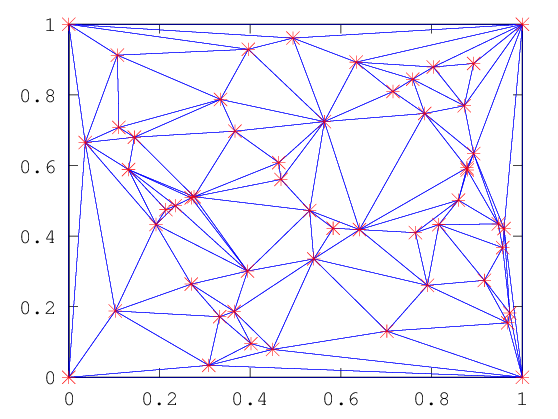

In [42]:
x0 = [0 0 1 1]';
y0 = [0 1 1 0]';
xy = [[x0 y0]; rand(50,2)];
delaunay(xy)

In [43]:
% sestavimo graf
T = delaunay(xy);
i = reshape(T,1,prod(size(T)));
j = reshape(T(:,[2 3 1]),1,prod(size(T)));
G  = sparse(i,j,1);
G = G + G';
G(find(G)) = 1; % vse povezave imajo enako utež

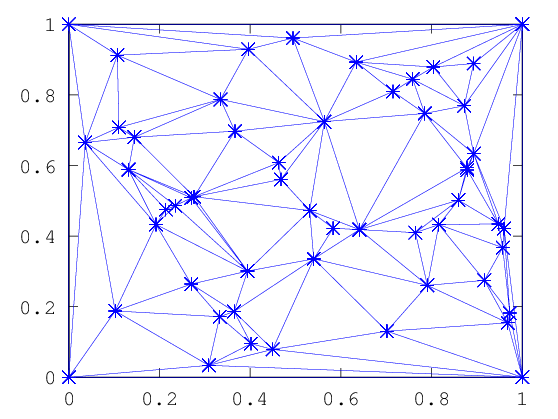

In [44]:
gplot(G,xy,'*-')

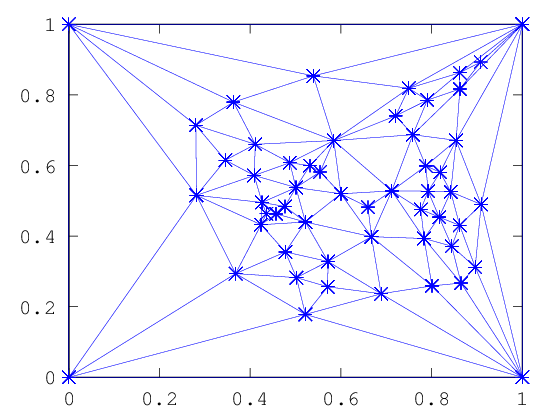

In [45]:
[x,y] = vlozi_graf(G,1:4,x0,y0);
gplot(G,[x y],'*-')

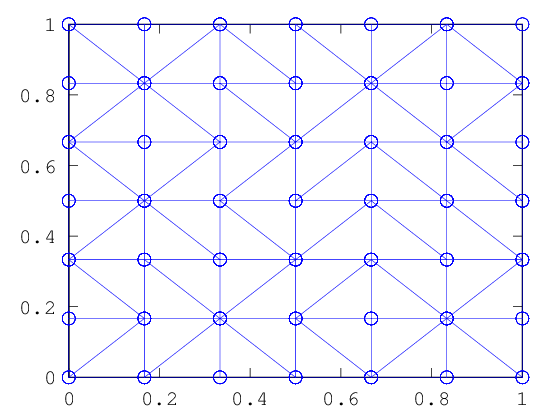

In [47]:
x =  linspace (0,1,7);
[xx,yy] = meshgrid(x,x);
T  = delaunay(xx,yy);
idx = find(xx==0 | xx==1 | yy==0 | yy==1); % rob kvadrata
i = reshape(T,1,prod(size(T))); j = reshape(T(:,[2 3 1]),1,prod(size(T)));
G = sparse(i,j,1); G = G + G'; G(find(G))=1;
xy = [reshape(xx,prod(size(xx)),1) reshape(yy,prod(size(yy)),1)];
gplot(G,xy,'o-')

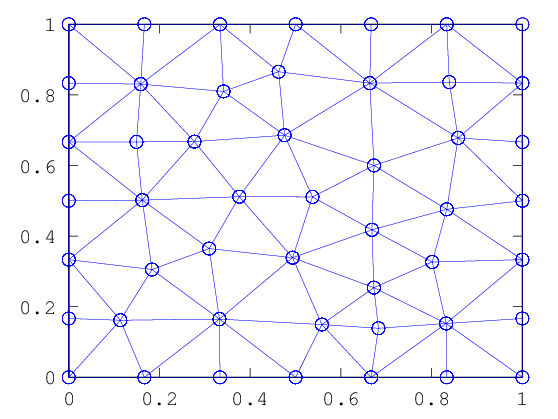

In [48]:
[x,y] = vlozi_graf(G,idx,xx(idx),yy(idx));
gplot(G,[x y],'o-')